# Simulation

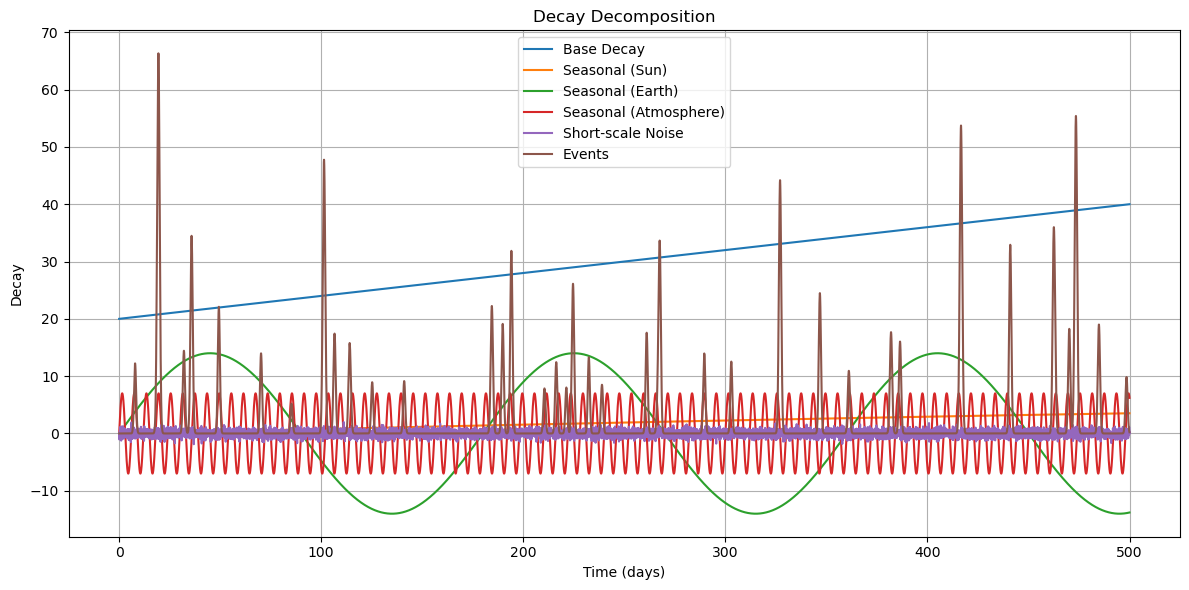

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
hours = 500*24
t = np.arange(hours)/24

# Base decay (linear)
base = 20 + 0.04 * t

# Seasonal variation (22-year cycle)
seasonal_sun = 5 * np.sin(2 * np.pi * t / (11 * 365))

# Seasonal variation (yearly cycle)
seasonal_earth = 14 * np.sin(2 * np.pi * t / (180))

# Seasonal variation (atmosphere)
seasonal_atm = 7 * np.sin(2 * np.pi * t / (6))

# Short-scale noise
short_noise = np.random.normal(0, 0.5, size=hours)

# Events (solar storms etc.)
np.random.seed(42)  # For reproducibility
num_events = 40
event_hour = np.sort(np.random.randint(0, hours, size=num_events))
event_index = event_hour/24
# Generate amplitudes with a distribution favoring lower values (e.g., exponential)
scale = 15  # Controls how quickly probability drops for higher amplitudes
event_amplitudes = np.random.exponential(scale=scale, size=num_events)
# Clip to max 80 to stay within original range
event_amplitudes += 5
event_amplitudes = np.clip(event_amplitudes, 5, 80)
events = np.zeros(hours)
for ed, amp in zip(event_index, event_amplitudes):
    # Width depends on amplitude + some randomness
    base_width = 0.5 + 0.002 * amp      # larger storms last longer
    width = np.random.normal(base_width, 0.02)  # add randomness
    width = max(0.5, width)  # prevent zero or negative width

    # Gaussian with variable width
    events += amp * np.exp(-0.5 * ((t - ed) / width) ** 2)

# Final decay
decay_with_events = base + seasonal_sun + seasonal_earth + seasonal_atm + short_noise + events
decay_without_events = base + seasonal_sun + seasonal_earth + seasonal_atm + short_noise

# plot decay decomposition
plt.figure(figsize=(12, 6))
plt.plot(t, base, label='Base Decay')
plt.plot(t, seasonal_sun, label='Seasonal (Sun)')
plt.plot(t, seasonal_earth, label='Seasonal (Earth)')
plt.plot(t, seasonal_atm, label='Seasonal (Atmosphere)')
plt.plot(t, short_noise, label='Short-scale Noise')
plt.plot(t, events, label='Events')
plt.xlabel('Time (days)')
plt.ylabel('Decay')
plt.title('Decay Decomposition')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

time = pd.date_range(start='2023-01-01 00:00:00', periods=len(t), freq='h').strftime('%Y-%m-%d %H:%M:%S')
time = pd.to_datetime(time)

# save decay to csv
decay_df = pd.DataFrame({
    'Time (days)': t,
    'Time': time,
    'Decay with Events': decay_with_events,
    'Decay without Events': decay_without_events
})
decay_df.to_csv('decay_decomposition_2.csv', index=False)

# Plot

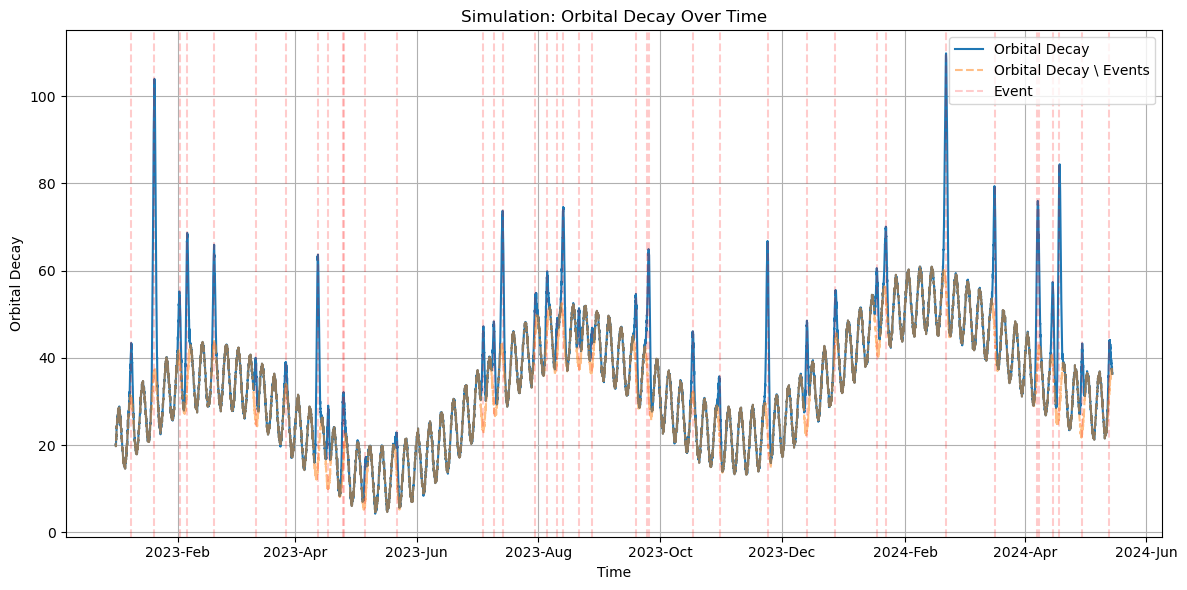

In [2]:
import matplotlib.dates as mdates
# Helper function for tick formatting
def format_ticks(ax, tick_interval, tick_step):
    if tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))                         
    elif tick_interval == 'daily':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif tick_interval == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=0)

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'monthly'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 2  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(GFOC_time, GFOC_data['orbital_decay'], label='Orbital Decay')
ax.plot(time, decay_with_events, label='Orbital Decay')
ax.plot(time, decay_without_events, label='Orbital Decay \ Events', linestyle='--', alpha=0.5)
for hour in event_hour:
    ax.axvline(time[hour], color='red', linestyle='--', alpha=0.2, label='Event' if hour == event_hour[0] else "")
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Simulation: Orbital Decay Over Time')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Lomb-Scargle

### 1.Orbital Decay with Events

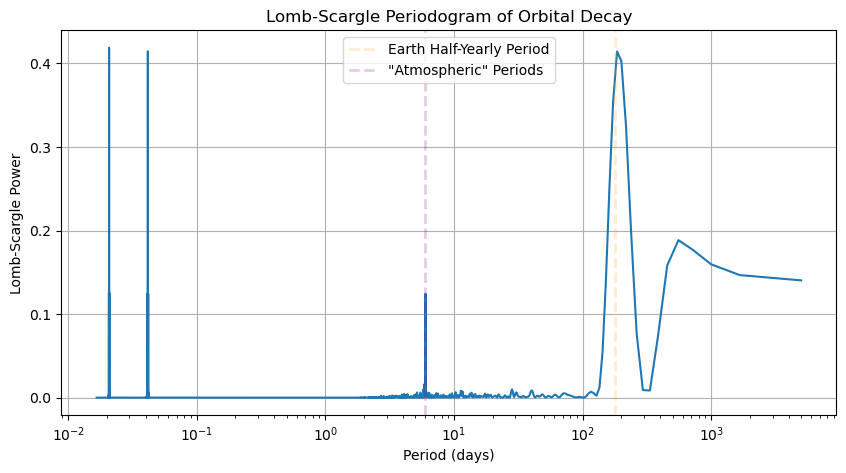

Strongest period: 0.02 days


In [3]:
from astropy.timeseries import LombScargle


y = decay_with_events

# Define frequency grid (cycles per day)
min_period = 0.01   # days
max_period = 4000  # days
frequency = np.linspace(1/max_period, 1/min_period, 10000)

# Compute Lomb-Scargle periodogram
ls = LombScargle(t, y)
power = ls.power(frequency)
frequency, power = LombScargle(t, y).autopower()

# Find the period with the highest power
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(1/frequency, power)
plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram of Orbital Decay')
plt.xscale('log')
plt.grid(True)

# Known Periods
plt.axvline(180, color='orange', linestyle='--', linewidth=2, alpha = 0.2, label='Earth Half-Yearly Period')
plt.axvline(6, color='purple', linestyle='--', linewidth=2, alpha = 0.2, label='"Atmospheric" Periods')

plt.legend()
plt.show()

print(f"Strongest period: {best_period:.2f} days")
# print(f"Strongest period: {best_period*24*60*60:.2f} seconds")

### 2. Orbital Decay without Events

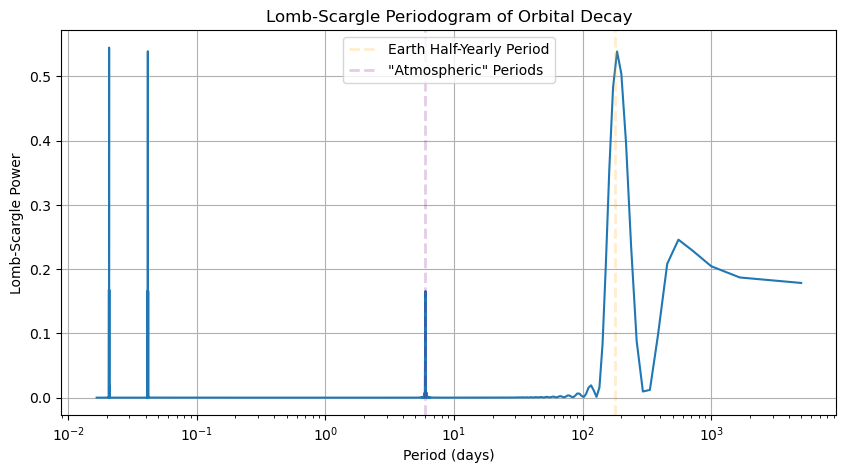

Strongest period: 0.02 days


In [4]:
y = decay_without_events

# Compute Lomb-Scargle periodogram
ls = LombScargle(t, y)
power_raw = ls.power(frequency)
# frequency, power = LombScargle(t, y).autopower()

# Find the period with the highest power
best_frequency = frequency[np.argmax(power_raw)]
best_period = 1 / best_frequency


# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(1/frequency, power_raw)
plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram of Orbital Decay')
plt.xscale('log')
plt.grid(True)

# Known Periods
plt.axvline(180, color='orange', linestyle='--', alpha = 0.2, linewidth=2, label='Earth Half-Yearly Period')
plt.axvline(6, color='purple', linestyle='--', alpha = 0.2, linewidth=2, label='"Atmospheric" Periods')

plt.legend()
plt.show()

print(f"Strongest period: {best_period:.2f} days")

### 3. Periodigram of the events

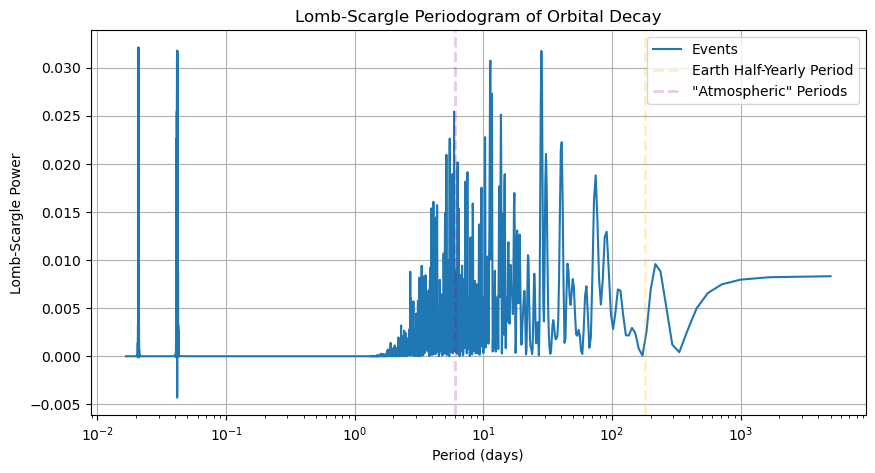

Strongest period: 0.02 days


In [5]:
y = events

# Compute Lomb-Scargle periodogram
ls = LombScargle(t, y)
power_events = ls.power(frequency)
# frequency, power = LombScargle(t, y).autopower()

# Find the period with the highest power
best_frequency = frequency[np.argmax(power_events)]
best_period = 1 / best_frequency

# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(1/frequency, power_events, label = "Events")
plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram of Orbital Decay')
plt.xscale('log')
plt.grid(True)

# Known Periods
plt.axvline(180, color='orange', linestyle='--', alpha = 0.2, linewidth=2, label='Earth Half-Yearly Period')
plt.axvline(6, color='purple', linestyle='--', alpha = 0.2, linewidth=2, label='"Atmospheric" Periods')

plt.legend()
plt.show()

print(f"Strongest period: {best_period:.2f} days")

There are three distinct categories of signals in the periodogram:
- data sampling rate and half data sampling rate (<-> daily and half-daily periods)
- "true" periodic signals (half-yearly period + harmonics)
- evnets (false periodic signals)

Compared to the simple model (one datapoint per day):
- events almost completely disappear from the periodgram
- enhanced the "atmospheric signal and reduced the overall noise --> atmospheric signal shows in periodogram

#### Maybe I need to change the event such that the width/duration of the events is different?

Making the width more random (before the width was always 3) did not really change. The positions of the peaks on the event periodogram stayed the same and the amplitude of the peaks stayed the same (compared to the sampling periods).

# STL

Here I want to test what STL does with my generated dataset.

### 1. Orbital Decay without Events

In [6]:
from statsmodels.tsa.seasonal import STL

df = pd.read_csv('decay_decomposition_2.csv')

using a period of 180.0 days
68.7 ms ± 296 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


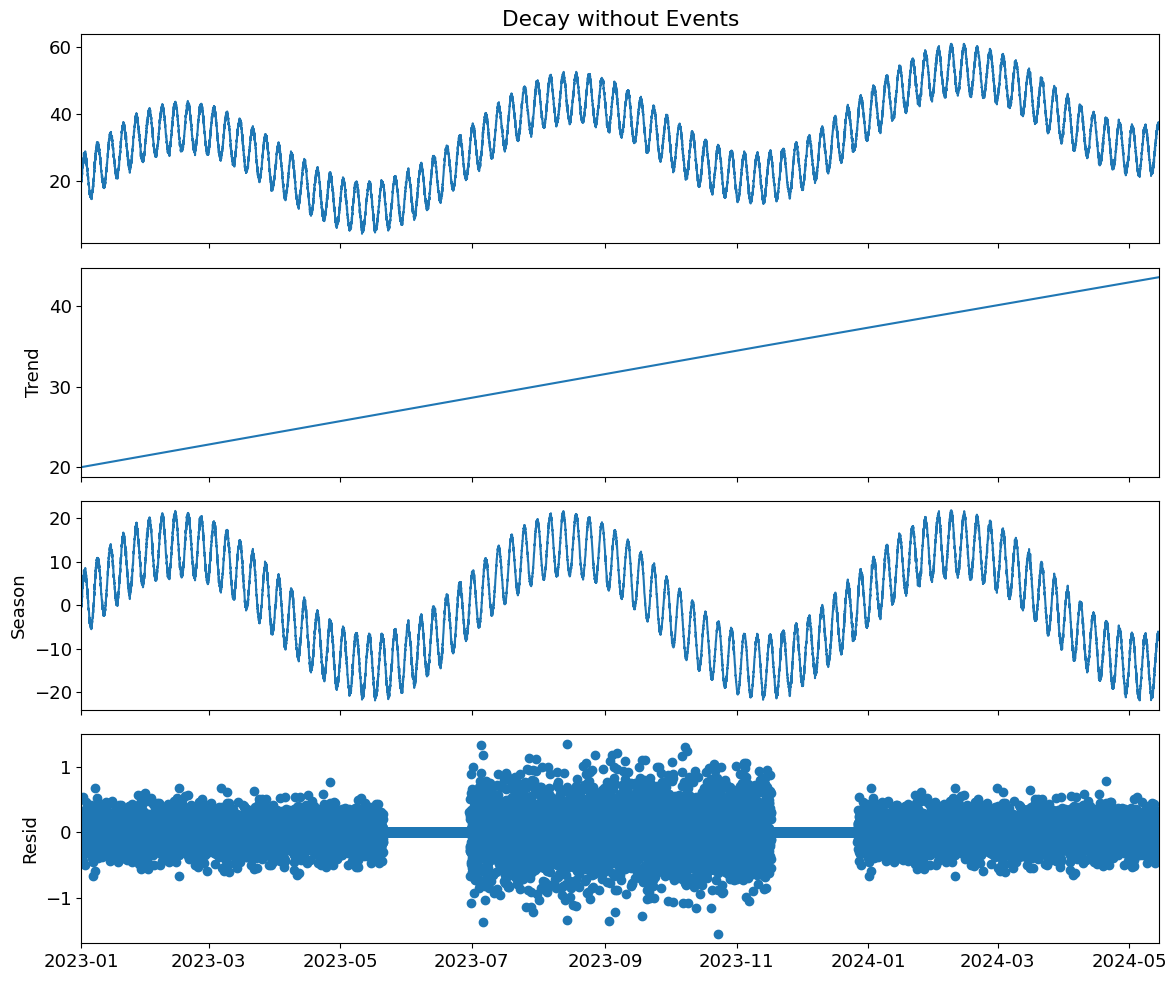

In [7]:

# Use time as index for y
y = df[['Time', 'Decay without Events']].copy()
y['Time'] = pd.to_datetime(y['Time'], format='%Y-%m-%d %H:%M:%S')
y.set_index('Time', inplace=True)
# y.describe()

# performance
period = 180*24
print(f"using a period of {period/24} days")
seasonal = period + ((period % 2) == 0)  # Ensure odd
low_pass_jump = seasonal_jump = int(0.15 * (period + 1))
trend_jump = int(0.15 * 1.5 * (period + 1))


mod = STL(
    y['Decay without Events'],
    period=period,
    seasonal=seasonal,
    seasonal_jump=seasonal_jump,
    trend_jump=trend_jump,
    low_pass_jump=low_pass_jump,
)
%timeit mod.fit()
res = mod.fit()

# plot
plt.rc("figure", figsize=(12, 10))
plt.rc("font", size=13)
fig = res.plot()

### 2. Orbital Decay with Events

using a period of 180.0 days
68.3 ms ± 347 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


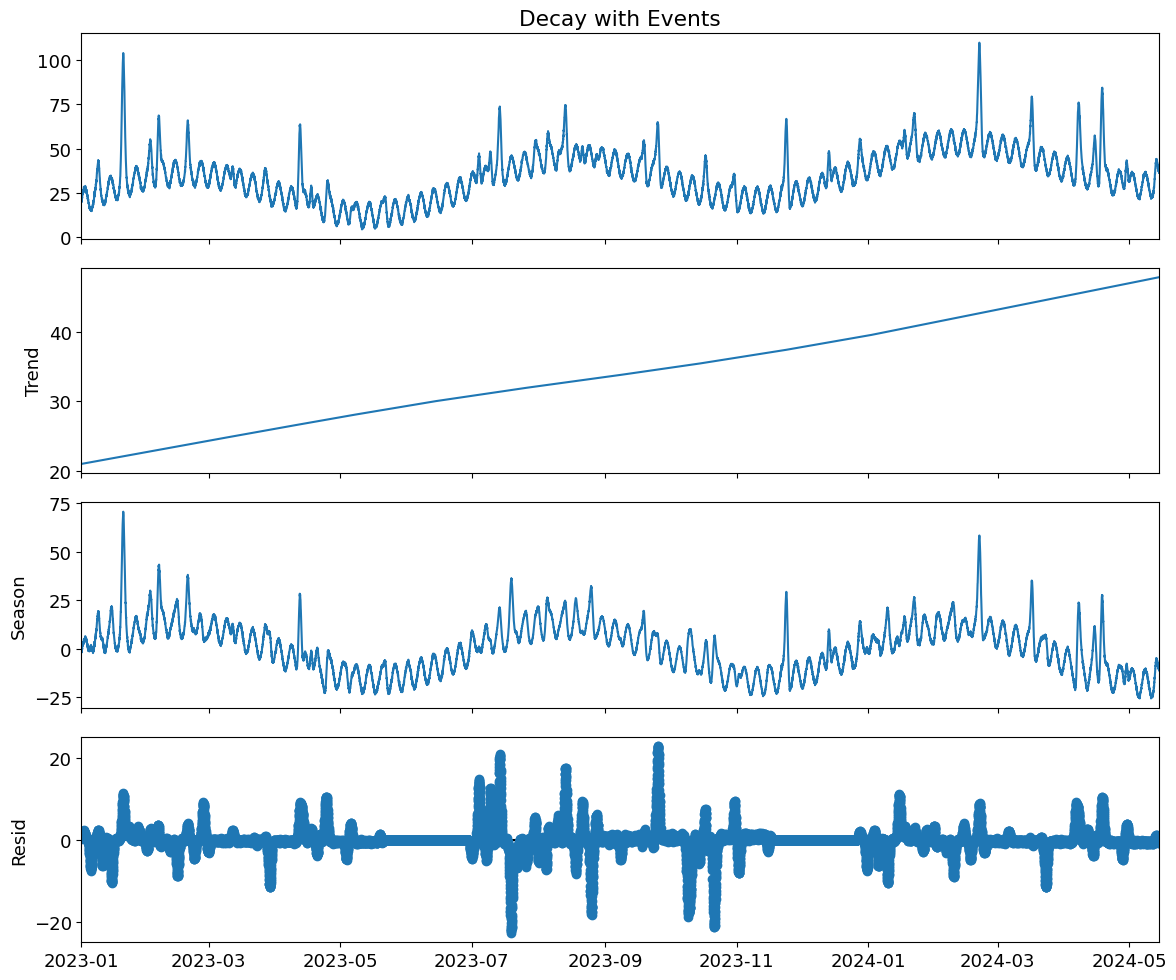

In [8]:
# Use time as index for y
y = df[['Time', 'Decay with Events']].copy()
y['Time'] = pd.to_datetime(y['Time'], format='%Y-%m-%d %H:%M:%S')
y.set_index('Time', inplace=True)
# y.describe()

# performance
period = 180*24
print(f"using a period of {period/24} days")
seasonal = period + ((period % 2) == 0)  # Ensure odd
low_pass_jump = seasonal_jump = int(0.15 * (period + 1))
trend_jump = int(0.15 * 1.5 * (period + 1))


mod = STL(
    y['Decay with Events'],
    period=period,
    seasonal=seasonal,
    seasonal_jump=seasonal_jump,
    trend_jump=trend_jump,
    low_pass_jump=low_pass_jump,
)
%timeit mod.fit()
res = mod.fit()

# plot
plt.rc("figure", figsize=(12, 10))
plt.rc("font", size=13)
fig = res.plot()

This result clearly shows that STL performs not as poorly - for hourly data comared to daily data - when there is nonperiodic noise (a.k.a. events) in the data. The Trend and Seasonal still show a similar result. However,
- STL almost fully absorbed the 6 day period into the seasonal of the 180 day period
- the Residual could also be used to detect the biggest events.
- the Residual can not be used to analyse the events directly as some of the amplitude is absorbed in the Seasonal.

# Questions

- could we use STL to calculate the "without events" curve by removing the data before and after an event flag?

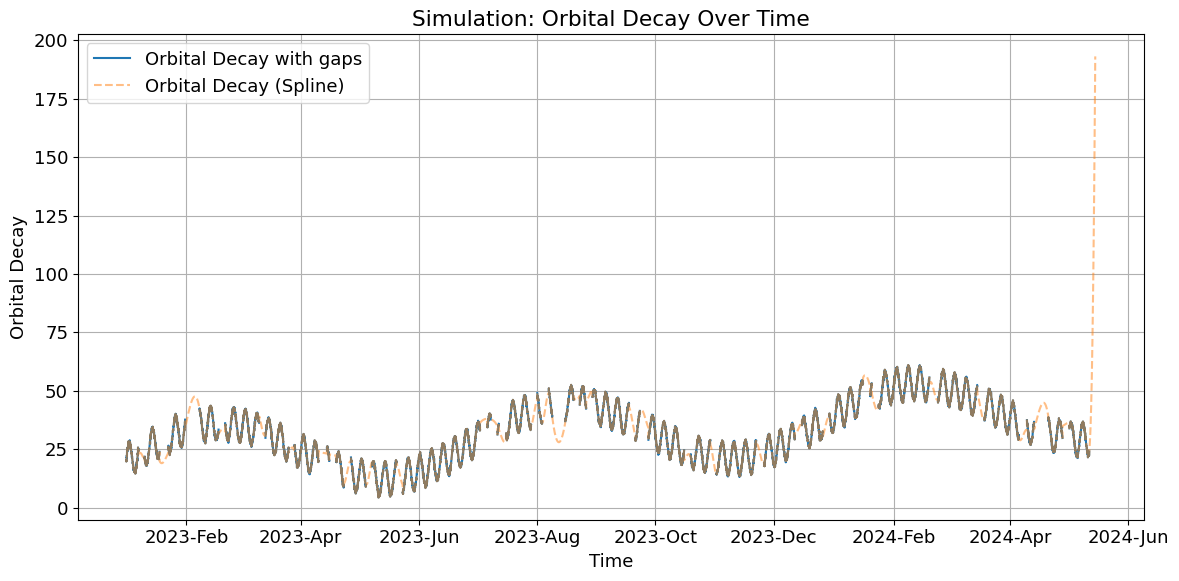

In [9]:
df['Decay filtered'] = df['Decay with Events'].where(
    (df['Decay with Events'] - df['Decay without Events']).abs() <= 0.1
)

df['Decay filtered (spline)'] = df['Decay filtered'].interpolate(method='spline', order=3)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(GFOC_time, GFOC_data['orbital_decay'], label='Orbital Decay')
ax.plot(time, df['Decay filtered'], label='Orbital Decay with gaps')
ax.plot(time, df['Decay filtered (spline)'], label='Orbital Decay (Spline)', linestyle='--', alpha=0.5)
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Simulation: Orbital Decay Over Time')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 1. Does STL still work with gaps?

using a period of 180.0 days
69.3 ms ± 612 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


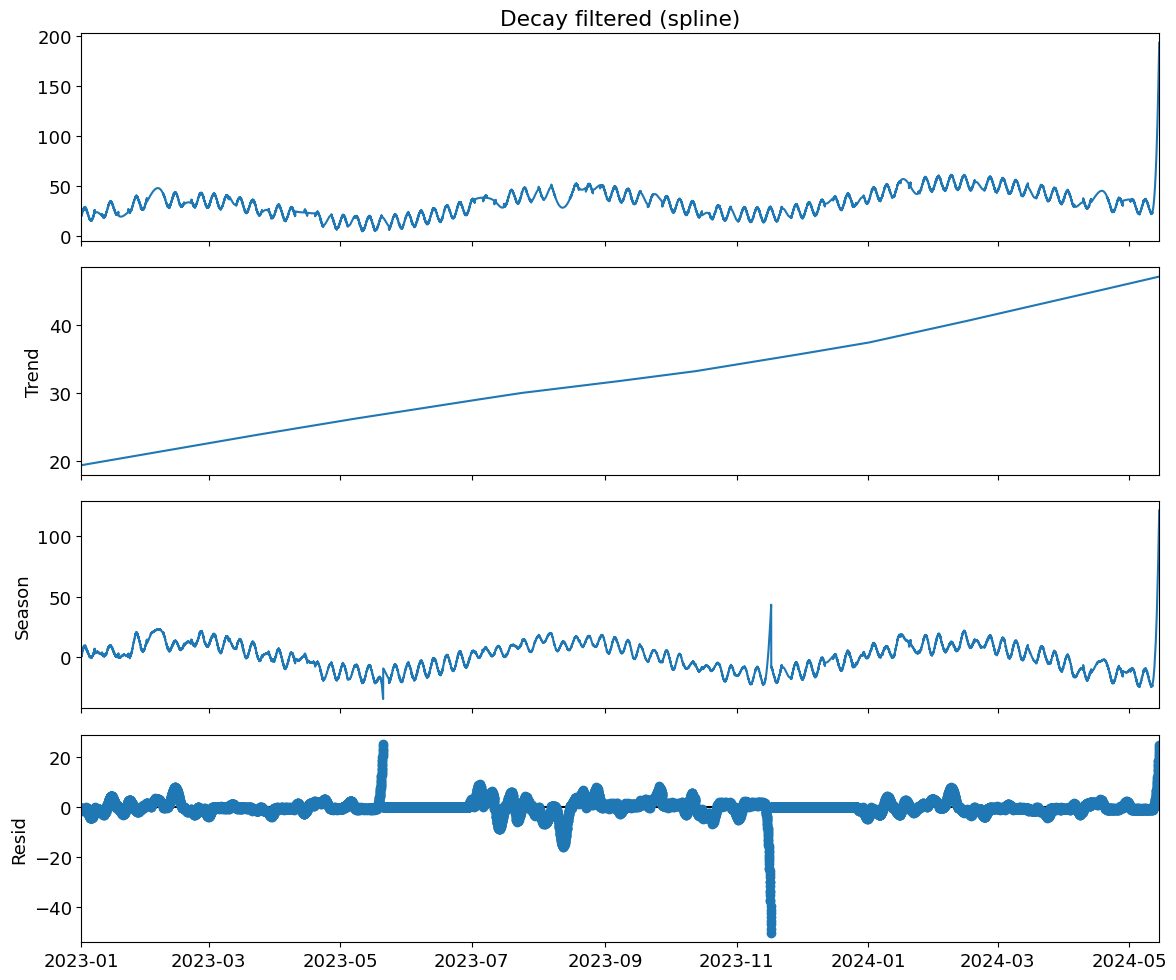

In [10]:
# Use time as index for y
y = df[['Time', 'Decay filtered (spline)']].copy()
y['Time'] = pd.to_datetime(y['Time'], format='%Y-%m-%d %H:%M:%S')
y.set_index('Time', inplace=True)
# y.describe()

# performance
period = 180*24
print(f"using a period of {period/24} days")
seasonal = period + ((period % 2) == 0)  # Ensure odd
low_pass_jump = seasonal_jump = int(0.15 * (period + 1))
trend_jump = int(0.15 * 1.5 * (period + 1))


mod = STL(
    y['Decay filtered (spline)'],
    period=period,
    seasonal=seasonal,
    seasonal_jump=seasonal_jump,
    trend_jump=trend_jump,
    low_pass_jump=low_pass_jump,
)
%timeit mod.fit()
res = mod.fit()

# plot
plt.rc("figure", figsize=(12, 10))
plt.rc("font", size=13)
fig = res.plot()